In [15]:
import torch
from torch import nn
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import transforms

import matplotlib.pyplot as plt


device = "cuda" if torch.cuda.is_available() else "cpu"


# load data

In [3]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
        transforms.Resize((32, 32)),

    ]
)

training_data= MNIST(
    root="data",
    train=True,
    download=True,
    transform=transform
)

test_data= MNIST(
    root="data",
    train=False,
    download=True,
    transform=transform
    )



100%|██████████| 9.91M/9.91M [00:00<00:00, 33.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.03MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.29MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.06MB/s]


# show example of data

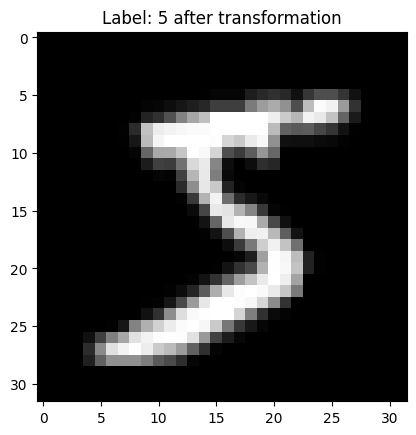

In [4]:
image = training_data[0][0] # first list -> first image
plt.imshow(image.squeeze(), cmap='gray')
plt.title(f"Label: {training_data[0][1]} after transformation")
plt.show()

# DataLoader : grouping data togather and make it itterable

In [5]:
train_dataloader = DataLoader(training_data, batch_size=128 , shuffle=True , drop_last =True)

test_dataloader = DataLoader(test_data, batch_size=128 , shuffle=True , drop_last = True )

In [6]:
for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([128, 1, 32, 32])
Shape of y: torch.Size([128]) torch.int64


# Building model
-  `nn.Module`, and initialize the neural network layers in __init__. Every nn.Module subclass implements the operations on input data in the forward method.

In [7]:
class model(nn.Module):
  def __init__(self):
    super(model, self).__init__()

    self.class_layar = nn.Sequential(
        nn.Flatten(),
        nn.Linear(32*32, 512),
        nn.ReLU(),
        nn.Linear(512,128),
        nn.ReLU(),
        nn.Linear(128,10))


  def forward(self, x):
    logits = self.class_layar(x)
    return logits



# training model

In [8]:

loss = nn.CrossEntropyLoss()

model = model().to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

def training(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  model.train() # start training mode

  for batch , (X,y) in enumerate(dataloader):
    X , y = X.to(device) , y.to(device)
    pred = model(X)
    loss = loss_fn(pred , y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step() # update w and b




training(train_dataloader, model, loss, optimizer)


# testing model performance

In [18]:

def test(dataloader , model , loss_fn):
  model.eval() # start evaluation
  model.to(device)

  all_labels =[]
  all_preds=[]
  total_loss = 0
  with torch.no_grad():
    for image , label in dataloader:
      image , label = image.to(device) , label.to(device)
      pred = model(image)

      total_loss += loss_fn(pred , label).item()

      _ , pred2 = torch.max(pred , axis=1) # get highest prob
      all_labels.extend(label.cpu().numpy())
      all_preds.extend(pred2.cpu().numpy())
      avg_loss = total_loss / len(dataloader)
      accuracy = accuracy_score(all_labels, all_preds)

  return avg_loss, accuracy, all_preds, all_labels

test_res= test(test_dataloader, model, loss)

In [19]:
print(f"test loss: {test_res[0]}")
print(f"test accuracy: {test_res[1]}")

test loss: 0.17738126514431757
test accuracy: 0.9486177884615384


# saving the model

In [14]:
torch.save(model.state_dict(), "mnist_model.pth")
# or save the whole model
# torch.save(model, "models/mnist_model_full.pth")